In [2]:
import numpy as np
import threading
import time, os, json
import cv2
import matplotlib.pyplot as plt
import multiprocessing as mp

from situtils import FPSTimes

In [19]:
class PositionTracker(FPSTimes):

    default_cfg = {
        "background_light": "background_light.png",
        "background_dark": "background_dark.png",
        "threshold": 40,
        "arena_x": 522,
        "arena_y": 372,
        "arena_radius": 330,
        "floor_radius": 287,
        "max_fps": 50,
        "file_path": "positions.csv",
        "floor_r_in_meters": 0.46,
        "flip_x": True,
        "flip_y": False
    }
    
    def __init__(self, status, video_stream, cfg):
        super(PositionTracker, self).__init__()
        
        self.status = status
        self.cfg = cfg
        self.video_stream = video_stream
        self.bg_light = cv2.imread(cfg['background_light'], 1)
        self.bg_dark  = cv2.imread(cfg['background_dark'], 1)
        self.background = self.bg_light  # light by default
        self.is_light = True
        self.x, self.y = None, None
        self.pixel_size = cfg['floor_r_in_meters'] / float(cfg['floor_radius'])
        self.contour = []
        self.stopped = False

        self.mask = np.zeros(shape=self.background.shape, dtype="uint8")
        cv2.circle(self.mask, (cfg['arena_x'], cfg['arena_y']), cfg['arena_radius'], (255,255,255), -1)

        with open(cfg['file_path'], 'w') as f:
            f.write("time,x,y\n")

    @property
    def x_in_meters(self):
        if self.x is None:
            return None
        return (self.cfg['arena_x'] - self.x) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
    
    @property
    def y_in_meters(self):
        if self.y is None:
            return None
        return (self.cfg['arena_y'] - self.y) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
            
    def start(self):
        self._th = threading.Thread(target=self.update, args=())
        self._th.start()
    
    def stop(self):
        self.stopped = True
        self._th.join()
        print('Position tracker stopped')
        
    def update(self):
        next_frame = time.time() + 1.0/self.cfg['max_fps']
        
        while not self.stopped:
            frame = self.video_stream.read()
            if frame is None:
                time.sleep(0.05)
                continue
                
            if time.time() < next_frame:
                time.sleep(0.001)
                continue
                
            self.count()  # count FPS
            self.detect_position(frame)
            next_frame += 1.0/self.cfg['max_fps']

            if self.status.value == 2 and self.x is not None:
                with open(self.cfg['file_path'], 'a') as f:
                    f.write(",".join([str(x) for x in (self.frame_times[-1], self.x, self.y)]) + "\n")         
       
    def switch_background(self):
        self.background = self.bg_dark if self.is_light else self.bg_light 
        self.is_light = not self.is_light
        
    def detect_position(self, frame):
        masked_frame = cv2.bitwise_and(src1=frame, src2=self.mask)

        # Substracts background from current frame
        subject = cv2.subtract(masked_frame, self.background)

        # Converts subject to grey scale
        subject_gray = cv2.cvtColor(subject, cv2.COLOR_BGR2GRAY)

        # Applies blur and thresholding to the subject
        kernel_size = (25,25)
        frame_blur = cv2.GaussianBlur(subject_gray, kernel_size, 0)
        _, thresh = cv2.threshold(frame_blur, self.cfg['threshold'], 255, cv2.THRESH_BINARY)

        # Finds contours and selects the contour with the largest area
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:
            return
        contour = contours[np.argmax(list(map(cv2.contourArea, contours)))]
        M = cv2.moments(contour)
        if (M['m00'] == 0):
            return

        self.x = int(M['m10'] / M['m00'])
        self.y = int(M['m01'] / M['m00'])
        self.contour = contour

### Testing position detection

In [8]:
import nbimporter
from camera import WebcamStream

with open(os.path.join('..', 'profiles', 'andrey_hippoSIT_test.json')) as json_file:
    cfg = json.load(json_file)

# controller status: 1 - detecting, 2 - detecting + logging
status = mp.Value('i', 1)

# let's use a webcam stream
vs = WebcamStream(cfg['camera'])
vs.start()  # stream runs in a separate thread

# init controller
pt_cfg = cfg['position']
pt_cfg['background_light'] = os.path.join('..', 'assets', 'background_light.png')
pt_cfg['background_dark'] = os.path.join('..', 'assets', 'background_dark.png')
pt = PositionTracker(status, vs, pt_cfg)
pt.start()
kernel_size = (25,25)

try:
    while True:
        frame = vs.read()
        if frame is not None:
            masked_frame = cv2.bitwise_and(src1=frame, src2=pt.mask)
            masked_frame = cv2.subtract(masked_frame, pt.background)
            #masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
            #masked_frame = cv2.GaussianBlur(masked_frame, kernel_size, 0)
        
            if pt.x is not None:
                color = (127, 255, 0) if status.value == 1 else (0, 0, 255)
                cv2.circle(masked_frame, (pt.x, pt.y), 2, color, -1)
                cv2.drawContours(masked_frame, [pt.contour], 0, color, 1, cv2.LINE_AA)
                cv2.putText(masked_frame, 'Animal: %.2f %.2f' % (pt.x_in_meters, pt.y_in_meters), (10, 40), \
                            cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
            
            cv2.putText(masked_frame, 'L' if pt.is_light else 'D', (10, 20), cv2.FONT_HERSHEY_DUPLEX, .5, (255, 255, 255))            
            cv2.imshow('Webcam', masked_frame)

        k = cv2.waitKey(33)
        if k == ord('q'):
            break
            
        if k == ord('s'):
            status.value = 2 if status.value == 1 else 1

        if k == ord('d'):
            pt.switch_background()
            
        if k == ord('r'):
            cv2.imwrite('frame.jpg', masked_frame)
            
finally:
    cv2.destroyAllWindows()
    vs.stop(), pt.stop()

Webcam stream 1024.0:768.0 at 20.00 FPS started
Camera released
Position tracker stopped


### Image sandbox

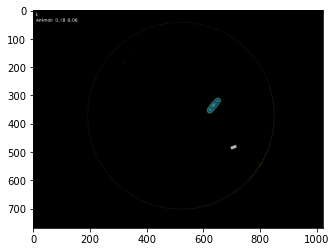

In [13]:
image = cv2.imread('substract.jpg')
plt.imshow(image)

In [17]:
image[0][0]

array([0, 0, 0], dtype=uint8)

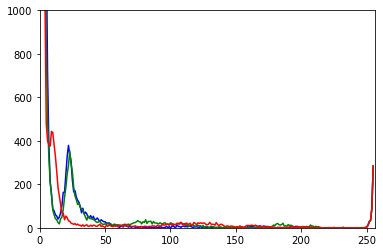

In [14]:
color = ('b','g','r')
for channel, col in enumerate(color):
    histr = cv2.calcHist([image],[channel],None,[256],[0,256])
    plt.plot(histr, color = col)
    plt.xlim([0,256])
    plt.ylim([0, 1000])